In [ ]:
!pip install qiskit==0.7.1
!pip install qiskit_aer==0.1.1
!pip install IBMQuantumExperience

In [5]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import plot_histogram,plot_state_city

from qiskit import BasicAer, execute, LegacySimulators

from qiskit import IBMQ


n=3

In [6]:
#IN/DECREMENT GATES FOR N=3

def increment_gate(qwc, q, subnode):
  
  cnx(qwc,q[2], q[1], q[0])
  cnx(qwc,q[2], q[1])
  qwc.x(q[2])
  
  for node in q:
    cnx(qwc,subnode,node)
   
  qwc.barrier()
  return qwc

def decrement_gate(qwc, q, subnode):
  
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, q[2], q[1], q[0])
  qwc.x(q[1])
  
  cnx(qwc,q[2], q[1])
  

  qwc.x(subnode[0])
  for node in q:
    cnx(qwc,subnode, node)
  qwc.x(subnode[0])


  return qwc
  
def stateVectorGenerator(circ):
  # Select the StatevectorSimulator from the Aer provider
  #localBE = BasicAer.get_backend('statevector_simulator')
  # Execute and get counts
  return execute(circ,ibmqBE).result().get_statevector(circ)
  
  
    
def ibmsim(circ):
  ibmqBE = IBMQ.get_backend('ibmq_qasm_simulator')
  return execute(circ,ibmqBE, shots=1000).result().get_counts(circ)  
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu3(np.pi/2, 0, 0, qubits[-2],qubits[-1])
        
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #B matrix (cry again, but opposite angle)
        qc.cu3(-np.pi/2, 0, 0, qubits[-2], qubits[-1])
        
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

In [41]:
def runQWC(qwc):
  for i in range(1):
    qwc.h(qsubnodes[0])
    increment_gate(qwc, qnodes, qsubnodes[0])
    decrement_gate(qwc,qnodes,qsubnodes[0])
  qwc.measure(qnodes, cnodes)

  return qwc

In [42]:
qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)

runQWC(qwc)
# qwc.draw(output='mpl')


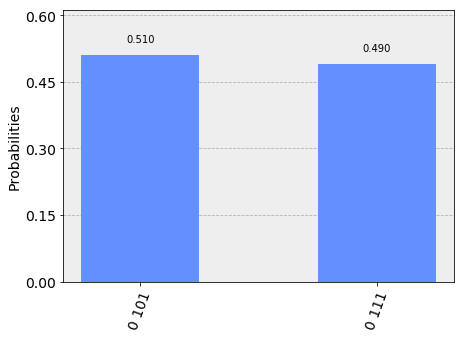

In [43]:
result = ibmsim(qwc)
#plot_state_city(result, title="result")
plot_histogram(result)

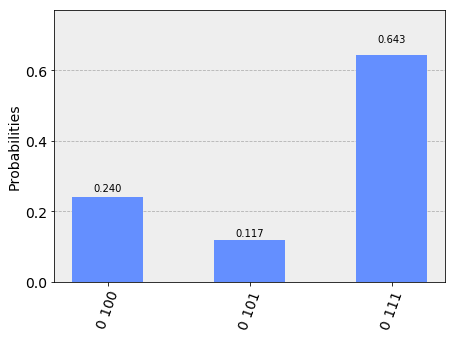

In [33]:
result = ibmsim(qwc)
#plot_state_city(result, title="result")
plot_histogram(result)

In [30]:
print(result)

{'0 011': 57, '0 000': 806, '0 010': 137}


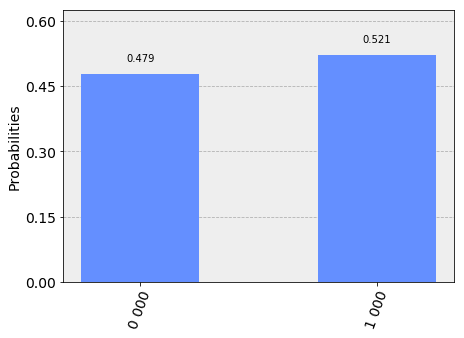

In [11]:
result = ibmsim(qwc)
#plot_state_city(result, title="result")
plot_histogram(result)

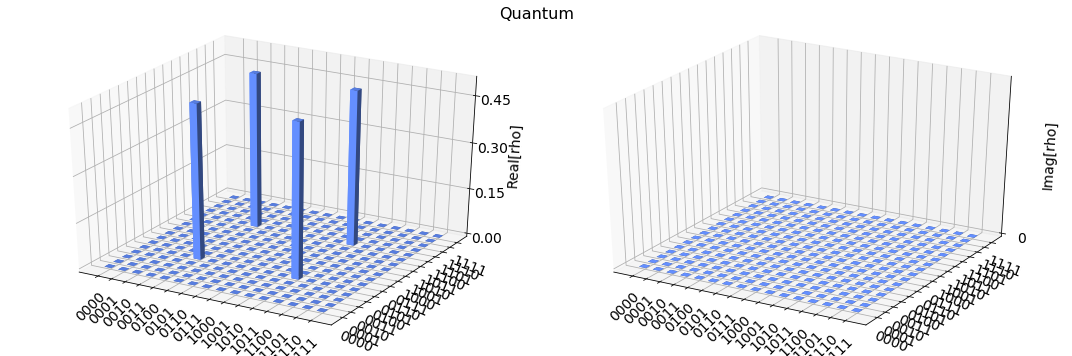

In [5]:
sv = stateVectorGenerator(qwc)
plot_state_city(sv, title='Quantum')

In [12]:
qwc.measure(qnodes, cnodes)
sv = stateVectorGenerator(qwc)
print(sv)
plot_state_city(sv, title='state post-measurement')


NameError: name 'ibmqBE' is not defined

n-qubit toffoli

In [7]:
IBMQ.active_accounts()

[]

In [ ]:
IBMQ.stored_accounts()


In [3]:
IBMQ.enable_account("53a94ea70a24c85cfac5f5e87e369d813f5efff70fed9c973b2b3637be5b2e0378da1921b5bbd786574e74d44dd8a64dda3095dbbda528b414c1b567476a87b2")

In [4]:
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [ ]:
#53a94ea70a24c85cfac5f5e87e369d813f5efff70fed9c973b2b3637be5b2e0378da1921b5bbd786574e74d44dd8a64dda3095dbbda528b414c1b567476a87b2